<a href="https://colab.research.google.com/github/hsimonfroy/diffusion-field-level/blob/main/tests/TSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling using the TSM objective


In [15]:
# !pip install --q diffrax
import jax
from jax import numpy as jnp, random as jr, jit, grad, vmap, tree, value_and_grad, debug
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## 1 Stochastic path to sample
$\newcommand{\cA}{\mathcal{A}}\newcommand{\cB}{\mathcal{B}}\newcommand{\cC}{\mathcal{C}}\newcommand{\cF}{\mathcal{F}}\newcommand{\cG}{\mathcal{G}}\newcommand{\cH}{\mathcal{H}}\newcommand{\cL}{\mathcal{L}}\newcommand{\cM}{\mathcal{M}}\newcommand{\cN}{\mathcal{N}}\newcommand{\cO}{\mathcal{O}}\newcommand{\cP}{\mathcal{P}}\newcommand{\cR}{\mathcal{R}}\newcommand{\cS}{\mathcal{S}}\newcommand{\cT}{\mathcal{T}}\newcommand{\cU}{\mathcal{U}}\newcommand{\cW}{\mathcal{W}}\newcommand{\cX}{\mathcal{X}}\newcommand{\cY}{\mathcal{Y}}\newcommand{\cZ}{\mathcal{Z}}\newcommand{\NN}{\mathbb{N}}\newcommand{\ZZ}{\mathbb{Z}}\newcommand{\QQ}{\mathbb{Q}}\newcommand{\RR}{\mathbb{R}}\newcommand{\CC}{\mathbb{C}}\newcommand{\KK}{\mathbb{K}}\newcommand{\SS}{\mathbb{S}}\newcommand{\eps}{\varepsilon}\newcommand{\ph}{\varphi}\newcommand{\pp}{\mathrm{p}}\newcommand{\qq}{\mathrm{q}}\newcommand{\HH}{\mathrm{H}}\newcommand{\PP}{\mathbb{P}}\newcommand{\EE}{\mathbb{E}}\newcommand{\OO}{\mathbb{O}}\newcommand{\Var}{\operatorname{\mathbb{V}\!ar}}\newcommand{\Cov}{\operatorname{\mathbb{C}\!ov}}\newcommand{\bs}{\boldsymbol}\newcommand{\dd}{\mathrm{d}}\newcommand{\dxdy}[2]{\frac{\dd #1}{\dd #2}}\newcommand{\pxpy}[2]{\frac{\partial #1}{\partial #2}}\newcommand{\abs}[1]{\left\lvert#1\right\rvert}\newcommand{\norm}[1]{\left\lVert#1\right\rVert}\newcommand{\T}{^\top}\newcommand{\ind}{\perp\!\!\!\perp}\newcommand{\1}{\mathbb{1}}\newcommand{\intint}[1]{\left[\!\left[#1\right]\!\right]}\newcommand{\lat}{x}\newcommand{\Lat}{X}\newcommand{\Ls}{\mathcal X}\newcommand{\obs}{y}\newcommand{\Obs}{Y}\newcommand{\Os}{\mathcal Y}\newcommand{\obst}{z}\newcommand{\Obst}{Z}\newcommand{\Ost}{\mathcal Z}$
* Let us have a target $x_1 \sim \pp_1$ and a stochastic Gaussian interpolation $$x_t = \alpha_t x_1 + \beta_t \eps,$$ with $\eps \sim \cN(\bs 0, I)$, scaling term $\alpha_t$, noise term $\beta_t$. We typically want $\alpha_0 = \beta_1 = 0$ and $\alpha_1 = \beta_0 = 1$. Then $$\pp_t = \alpha_t^{-1}\pp_1(\alpha_t^{-1} \cdot) * \cN(0, \beta_t^2).$$
* Let us define drift term $f_t(x) := \frac{\dot \alpha_t}{\alpha_t}x$ and diffusion term $g_t^2 := 2( \frac{\dot \alpha_t}{\alpha_t}\beta_t^2 - \beta_t \dot \beta_t ) = - \alpha_t^2 \dot{\left(\frac{\beta_t^2}{\alpha_t^2}\right)}$
* Then, the 3 following processes $(x(t))_{t}$ admits the same marginals $\forall t, x(t) = x_t \sim \pp_t$:
	* ODE $\begin{cases}\exists t_0, x(t_0) \sim x_{t_0}\\ 	\dd x = v_t(x) \dd t \quad\textrm{with}\quad v_t:= f_t+\frac{g_t^2}{2}\nabla\log\pp_t\end{cases}$
	* Backward (noising) SDE $\begin{cases}x(1) \sim x_{1}\\ 	\dd x = \left(v_t-\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd \tilde W = f_t\ \dd t + g_t\ \dd \tilde W \end{cases}$  
	  with $\tilde W$ a backward Wiener process.
	* Forward (denoising) SDE $\begin{cases}x(0) \sim x_{0}\\ 	\dd x = \left(v_t+\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd W = \left(f_t+g_t^2\nabla\log\pp_t\right) \dd t + g_t\ \dd W\end{cases}$    
	  with $W$ a forward Wiener process.

* Noise scheduling:
	* Variance Preserving, $\beta_t^2 = 1-\alpha_t^2$, which implies $f_t(x) = \frac{\dot \alpha_t}{\alpha_t}x = \frac{g_t^2}{2}x$  
	  Typically $g_t^2 = t g_m^2 + (1-t) g_M^2$, then $\alpha_t = \exp((g_m^2(t^2-1) - g_M^2(1-t)^2)/4)$
	* Variance Exploding, $\alpha_t = 1$, which implies $f_t(x) = 0$ and $g_t^2 = -\dot{\beta_t^2} = -2\beta_t \dot \beta_t$  
	  Typically $\beta_t = \beta_m^t \beta_M^{1-t}$, then $g_t^2 = 2\beta^2 \log\left(\frac{\beta_M}{\beta_m}\right)$
	* Optimal Transport, $\alpha_t = t = 1 - \beta_t$, which implies $f_t(x) = \frac{x}{t}$, $g_t^2 = 2\left(\frac{1}{t} - 1\right)$

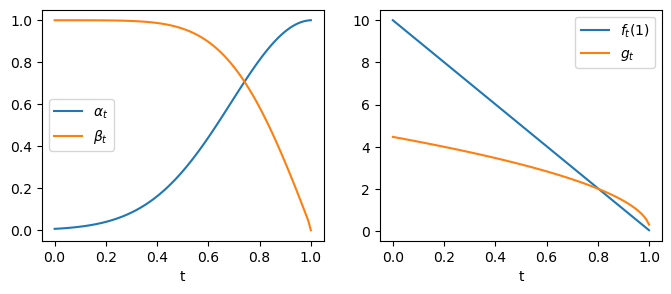

In [16]:
# Defining noise scheduling
def alpha_OT(t):
    return t

def beta_OT(t):
    return 1 - t

def alpha_VP(t, g2min=0.1, g2max=20):
    """https://huggingface.co/docs/diffusers/v0.13.0/en/api/schedulers/score_sde_vp"""
    return jnp.exp((g2min * (t**2 - 1) - g2max * (1 - t)**2) / 4)

def beta_VP(t, g2min=0.1, g2max=20.):
    alpha = alpha_VP(t, g2min, g2max)
    return (1 - alpha**2)**.5

def alpha_VE(t):
    return jnp.ones_like(t)

def beta_VE(t, betamin=0.01, betamax=100.):
    """https://huggingface.co/docs/diffusers/v0.13.0/en/api/schedulers/score_sde_ve"""
    return betamin**t * betamax**(1 - t)

# Current scheduling
alpha = alpha_VP
beta = beta_VP
drift = lambda t, y, args: grad(alpha)(t) / alpha(t) * y # General formula
diffusion = lambda t, y, args: (- alpha(t)**2 * grad(lambda t: (beta(t) / alpha(t))**2)(t))**.5 * jnp.ones_like(y) # General formula
def noise(key, t, x1):
    return alpha(t) * x1 + beta(t) * jr.normal(key, jnp.shape(x1))

g2min, g2max = 0.1, 20.
drift = lambda t, y, args: (t * g2min + (1-t) * g2max) / 2 * y # VP
diffusion = lambda t, y, args: (t * g2min + (1-t) * g2max)**.5 * jnp.ones_like(y) # VP
# betamin, betamax = 0.01, 100.
# drift = lambda t, y, args: jnp.zeros_like(y) # VE
# diffusion = lambda t, y, args: (2 * beta(t)**2 * jnp.log(betamax / betamin))**.5 * jnp.ones_like(y) # VE
# drift = lambda t, y, args: y / t # OT
# diffusion = lambda t, y, args: (2 * (1 / t - 1))**.5 * jnp.ones_like(y) # OT

tlin = jnp.linspace(0,1,100)
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(tlin, alpha(tlin), label="$\\alpha_t$");
plt.plot(tlin, beta(tlin), label="$\\beta_t$");
plt.xlabel("t"), plt.legend();

plt.subplot(122)
plt.plot(tlin, vmap(drift)(tlin, jnp.ones_like(tlin), None), label="$f_t(1)$");
plt.plot(tlin, vmap(diffusion)(tlin, jnp.ones_like(tlin), None), label="$g_t$");
plt.xlabel("t"), plt.legend();

In [17]:
def make_dist(alpha=1., beta=0., d=2, sigma0=1., probs=[0.5, 0.5]):
  """
  Returns a mixture of two d-dimensional Multivariate Gaussians.

  Args:
    d: The dimension of the Gaussian distributions.
    probs: The probabilities for the categorical distribution.
    alpha: The scaling factor for the mean of the Gaussians.
    beta: The standard deviation of the noise convolved with the Gaussians.
  """
  return tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=probs),
      components_distribution=tfd.MultivariateNormalDiag(
          loc=jnp.stack([-alpha * jnp.ones(d), alpha * jnp.ones(d)]),
          scale_diag=jnp.ones((2, d)) * ((alpha * sigma0)**2 + beta**2)**.5)
  )

def make_path(t=1, d=2, sigma0=1., probs=[0.5, 0.5]):
  return make_dist(alpha=alpha(t), beta=beta(t), d=d, sigma0=sigma0, probs=probs)

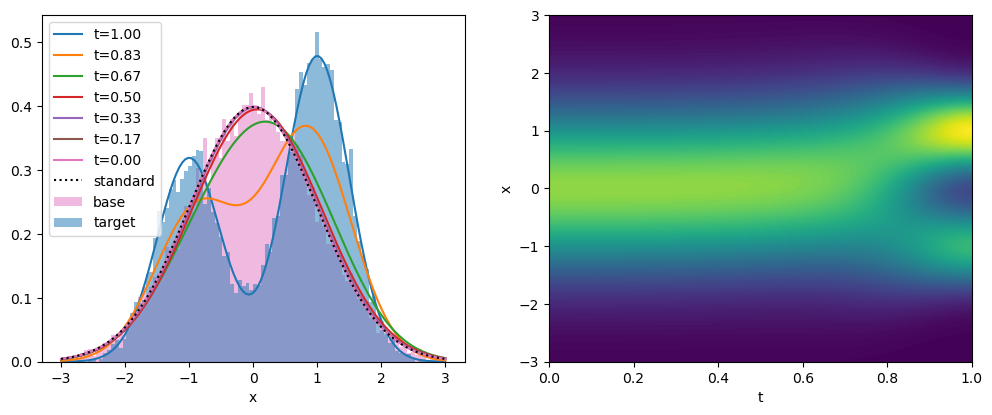

In [18]:
d = 1
sigma0 = 0.5
probs=[0.4, 0.6]
n_samples = 10000

make_path = partial(make_path, d=d, sigma0=sigma0, probs=probs)
base = make_path(0.)
target = make_path(1.)
base_samples = base.sample(n_samples, jr.key(0))
target_samples = target.sample(n_samples, jr.key(1))

n_discr = 128
xlim = (-3,3)
if d == 1:
    xlin = jnp.linspace(*xlim, n_discr)[:,None]
    tlin = jnp.linspace(0, 1, 7)[::-1]
    
    plt.figure(figsize=(12,4.5))
    plt.subplot(1,2,1)
    for t in tlin:
        plt.plot(xlin, make_path(t).prob(xlin), label=f't={t:.2f}');
    
    plt.plot(xlin, tfd.Normal(loc=0., scale=1.).prob(xlin), ':k', label='standard');
    plt.hist(base_samples[:,0], 100, range=xlim, label='base', color=f'C{len(tlin)-1}', density=True, alpha=0.5);
    plt.hist(target_samples[:,0], 100, range=xlim, label='target', color='C0', density=True, alpha=0.5);
    plt.xlabel('x'), plt.legend()

    plt.subplot(1,2,2)
    tt, xx = jnp.meshgrid(jnp.linspace(0, 1, n_discr), jnp.linspace(*xlim, n_discr))
    tx = jnp.stack([tt.flatten(), xx.flatten()], axis=1)
    def prob_at_tx(tx):
        t, x = tx
        dist_t = make_path(t)
        return dist_t.prob(x[...,None]).squeeze()
    
    probas = vmap(prob_at_tx)(tx).reshape(n_discr, n_discr)
    plt.contourf(tt, xx, probas, 128)
    plt.xlabel('t'), plt.ylabel('x');

elif d == 2:
    plt.figure(figsize=(5,5))
    xlin = jnp.linspace(*xlim, n_discr)
    xx, yy = jnp.meshgrid(xlin, xlin)
    xy = jnp.stack([xx.flatten(), yy.flatten()], axis=1)
    tlin = [0., 0.8, 1.]
    handles = []
    labels = []

    for it, t in enumerate(tlin):
        zz = make_path(t).prob(xy).reshape(xx.shape)
        quad = plt.contour(xx, yy, zz, alpha=1., levels=2, colors=f'C{it}')
        handles.append(quad.legend_elements()[0][0])
        labels.append(f't={t:.2f}')
        
    plt.scatter(*base_samples.T, marker='+', label='base', alpha=0.1, color=f'C{len(tlin)-1}');
    plt.scatter(*target_samples.T, marker='+', label='target', alpha=0.1, color='C0');
    plt.xlim(xlim), plt.ylim(xlim)
    plt.gca().set_aspect(1.)
    plt.legend(handles, labels);

Let's try to verify that our integration time is going to be good enough, by running backward and forward SDEs, as well as corresponding (forward) ODE. We should obtain base distribution for the former one, and the target distribution for the latter two.

In [6]:
from diffrax import (diffeqsolve, ControlTerm, MultiTerm, ODETerm, VirtualBrownianTree, 
                     ConstantStepSize, PIDController, SaveAt, Euler, Tsit5)

dt0 = 3e-4
eps = 0.
# dt0 = 1e-2
# eps = 1e-6

def backward_sde(seed, x1):
    t0, t1 = eps, 1 - eps
    back_drift = lambda t, y, args: -drift(1 - t, y, args)
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(d,), key=seed)

    # from lineax import DiagonalLinearOperator # NOTE diffrax >= 0.6.0
    # back_diffusion = lambda t, y, args: DiagonalLinearOperator(diffusion(1 - t, y, args))
    # terms = MultiTerm(ODETerm(back_drift), ControlTerm(back_diffusion, brownian_motion))
    # See https://docs.kidger.site/diffrax/devdocs/srk_example/
    # solver = ShARK() # NOTE diffrax >= 0.6.0
    # controller = PIDController(rtol=1e-3, atol=1e-6, pcoeff=0.1, icoeff=0.3, dcoeff=0.)

    from diffrax import WeaklyDiagonalControlTerm # NOTE diffrax <= 0.5.0
    back_diffusion = lambda t, y, args: diffusion(1 - t, y, args)
    terms = MultiTerm(ODETerm(back_drift), WeaklyDiagonalControlTerm(back_diffusion, brownian_motion))
    solver = Euler()
    controller = ConstantStepSize()

    saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
    sol = diffeqsolve(terms, solver, t0, t1, dt0=dt0, y0=x1, stepsize_controller=controller, saveat=saveat)
    return sol.ts[::-1], sol.ys

def forward_sde(seed, x0, score=lambda t, y, args: jnp.zeros_like(y)):
    t0, t1 = eps, 1 - eps
    forw_drift = lambda t, y, args: drift(t, y, args) + diffusion(t, y, args)**2 * score(t, y, args)
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(d,), key=seed)

    # from lineax import DiagonalLinearOperator # NOTE diffrax >= 0.6.0
    # forw_diffusion = lambda t, y, args: DiagonalLinearOperator(diffusion(t, y, args))
    # terms = MultiTerm(ODETerm(back_drift), ControlTerm(forw_diffusion, brownian_motion))
    # See https://docs.kidger.site/diffrax/devdocs/srk_example/
    # solver = ShARK() # NOTE diffrax >= 0.6.0
    # controller = PIDController(rtol=1e-3, atol=1e-6, pcoeff=0.1, icoeff=0.3, dcoeff=0.)

    from diffrax import WeaklyDiagonalControlTerm # NOTE diffrax <= 0.5.0
    terms = MultiTerm(ODETerm(forw_drift), WeaklyDiagonalControlTerm(diffusion, brownian_motion))
    solver = Euler()
    controller = ConstantStepSize()

    saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
    sol = diffeqsolve(terms, solver, t0, t1, dt0=dt0, y0=x0, stepsize_controller=controller, saveat=saveat)
    return sol.ts, sol.ys

def flow_ode(x0, score=lambda t, y, args: jnp.zeros_like(y)):
    t0, t1 = eps, 1 - eps
    vf = lambda t, y, args: drift(t, y, args) + diffusion(t, y, args)**2 / 2 * score(t, y, args)
    terms = ODETerm(vf)
    solver = Tsit5()
    controller = PIDController(rtol=1e-3, atol=1e-6, pcoeff=0., icoeff=1., dcoeff=0.)
    saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
    sol = diffeqsolve(terms, solver, t0, t1, dt0=dt0, y0=x0, stepsize_controller=controller, saveat=saveat)
    return sol.ts, sol.ys

In [7]:
seeds = jr.split(jr.key(0), n_samples)
ts_back, xs_back = jit(vmap(backward_sde))(seeds, target_samples)

score_target = lambda t, y, args: grad(make_path(t).log_prob)(y)
forward_sde_target = jit(vmap(partial(forward_sde, score=score_target)))
ts_forw, xs_forw = forward_sde_target(seeds, base_samples)

flow_ode_target = jit(vmap(partial(flow_ode, score=score_target)))
ts_flow, xs_flow = flow_ode_target(base_samples)

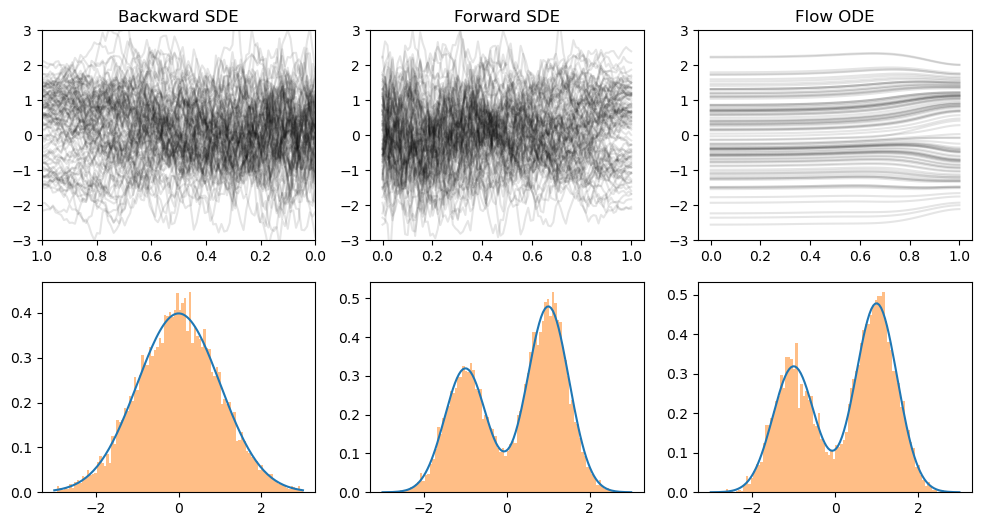

In [8]:
# Let's take a look at the trajectories
if d == 1:
    plt.figure(figsize=(12,6))
    plt.subplot(231)
    for i in range(100):
        plt.plot(ts_back[i], xs_back[i], 'k', alpha=0.1);
    plt.ylim(xlim), plt.xlim(1.,0.)
    plt.title('Backward SDE')

    plt.subplot(232)
    for i in range(100):
        plt.plot(ts_forw[i], xs_forw[i], 'k', alpha=0.1);
    plt.ylim(xlim)
    plt.title('Forward SDE')

    plt.subplot(233)
    for i in range(100):
        plt.plot(ts_flow[i], xs_flow[i], 'k', alpha=0.1);
    plt.ylim(xlim)
    plt.title('Flow ODE')

    plt.subplot(234)
    plt.plot(xlin, base.prob(xlin));
    plt.hist(xs_back[:,-1,0], 100, range=xlim, density=True, alpha=0.5);

    plt.subplot(235)
    plt.plot(xlin, target.prob(xlin));
    plt.hist(xs_forw[:,-1,0], 100, range=xlim, density=True, alpha=0.5);

    plt.subplot(236)
    plt.plot(xlin, target.prob(xlin));
    plt.hist(xs_flow[:,-1,0], 100, range=xlim, density=True, alpha=0.5);

elif d == 2:
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    zz = base.prob(xy).reshape(xx.shape)
    quad = plt.contour(xx, yy, zz, alpha=1., levels=5, colors='C1')
    plt.scatter(*xs_back[:,-1].T, marker='+', alpha=0.1, color='C0');
    
    for i in range(10):
        plt.plot(*xs_back[i].T, 'k', alpha=0.3);
    plt.xlim(xlim), plt.ylim(xlim)
    plt.gca().set_aspect(1.)
    plt.title('Backward SDE')

    plt.subplot(132)
    zz = target.prob(xy).reshape(xx.shape)
    quad = plt.contour(xx, yy, zz, alpha=1., levels=5, colors='C1')
    plt.scatter(*xs_forw[:,-1].T, marker='+', alpha=0.1, color='C0');

    for i in range(10):
        plt.plot(*xs_forw[i].T, 'k', alpha=0.3);
    plt.xlim(xlim), plt.ylim(xlim)
    plt.gca().set_aspect(1.)
    plt.title('Forward SDE')

    plt.subplot(133)
    zz = target.prob(xy).reshape(xx.shape)
    quad = plt.contour(xx, yy, zz, alpha=1., levels=5, colors='C1')
    plt.scatter(*xs_flow[:,-1].T, marker='+', alpha=0.1, color='C0');

    for i in range(10):
        plt.plot(*xs_flow[i].T, 'k', alpha=0.3);
    plt.xlim(xlim), plt.ylim(xlim)
    plt.gca().set_aspect(1.)
    plt.title('Flow ODE');

## 2 Score network and associated proposal probability
* Lagrangian formulation: the continuous change of variable formula along a particle trajectory yields $\dd \log \pp_t(x(t)) = - \nabla \cdot v_t(x(t)) \ \dd t$, i.e.$$\log \pp_\tau(x(\tau)) = \log \pp_0(x(0)) + \int_\tau^0 \nabla \cdot v_t(x(t))\dd t$$
* Eulerian formulation: the continuity equation yields $\partial_t \pp_t = -\nabla \cdot (\pp_t v_t)$, i.e. $$\partial_t \log \pp_t = -\nabla \cdot v_t - \nabla \log \pp_t \cdot v_t$$

In [9]:
import flax.linen as nn

class ScoreNN(nn.Module):
    @nn.compact
    def __call__(self, t, x):
        # Encoding time
        t = 1 - t
        freqs = (jnp.arange(10)+1)*np.pi
        t = freqs * jnp.atleast_1d(t)
        t = jnp.concatenate([jnp.sin(t), jnp.cos(t)],axis=-1)
        # Building network
        xin = x
        x = jnp.concatenate([jnp.atleast_1d(x), t])
        x = nn.Dense(features=64)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=64)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=64)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=d)(x)
        return x - xin

scorenn = ScoreNN()
params = scorenn.init(jr.key(0), jnp.zeros(1), jnp.zeros(d))
# params = tree.map(lambda x: jnp.zeros_like(x), params)

@jax.jit
@partial(vmap, in_axes=(None, 0))
def sample_sde(params, seed):
    seed_x0, seed_sde = jr.split(seed)
    x0 = base.sample(seed=seed_x0)
    return forward_sde(seed_sde, x0, lambda t, y, args: scorenn.apply(params, t, y))
    # return forward_sde(seed_sde, x0, score_target)

In [10]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree
# Compute sampling probability.
# We naively recompute a whole trajectory for this though we could later think
# about sampling and computing probability at the same time.

@jit
@partial(vmap, in_axes=(None, 0))
def logp_sde(params, x1):
    # Let us use the ontinuous change of variable formula
    # log p_t(x(t)) = log p_0(x(0)) - \int_0^t div(vf(x(s), s)) ds
    t0, t1 = 1 - eps, eps
    vf = lambda t, y, args: drift(t, y, args) + diffusion(t, y, args)**2 / 2 * scorenn.apply(params, t, y)
    # vf = lambda t, y, args: drift(t, y, args) + diffusion(t, y, args)**2 / 2 * score_target(t, y, args)

    def logp_drift(t, y, args):
        x, logp = y
        dx = vf(t, x, args)
        # div = jnp.trace(jax.jacfwd(lambda xx: vf(t, xx, args))(x)) # Full Jac
        div = jnp.trace(jax.jacrev(lambda xx: vf(t, xx, args))(x)) # Full Jac
        # div = # Hutchinson trace estimator
        return dx, div

    terms = ODETerm(logp_drift)
    solver = Tsit5()
    controller = PIDController(rtol=1e-3, atol=1e-6, pcoeff=0., icoeff=1., dcoeff=0.)
    # solver = Euler()
    # controller = ConstantStepSize()
    saveat = SaveAt(t1=True)
    y0 = (x1, 0.0)

    sol = diffeqsolve(terms, solver, t0, t1, dt0=-dt0, y0=y0, stepsize_controller=controller, saveat=saveat,
                    #   max_steps=int(1e5)
                      )
    x0, logp = tree.map(lambda x: x[-1], sol.ys)
    return base.log_prob(x0) + logp

ts.shape: (10000, 100), xs.shape: (10000, 100, 1)


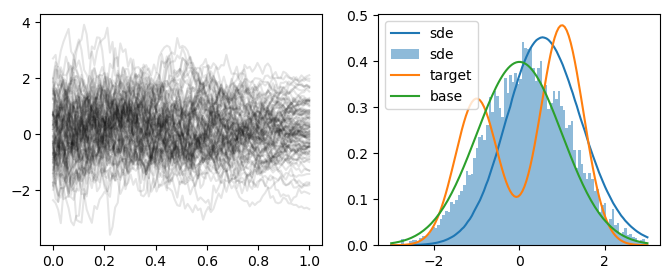

In [11]:
# Let's plot the untrained process
def plot_result(params, n_samples=10000):
    ts, xs = sample_sde(params, jr.split(jr.key(0), n_samples))
    print(f"ts.shape: {ts.shape}, xs.shape: {xs.shape}")

    if d == 1:
        logps = logp_sde(params, xlin)

        plt.figure(figsize=(8,3))
        plt.subplot(121)
        for i in range(100):
            plt.plot(ts[i], xs[i], 'k', alpha=0.1);

        plt.subplot(122)
        plt.plot(xlin, jnp.exp(logps), 'C0', label="sde");
        plt.hist(xs[:,-1,0], 100, range=xlim, density=True, alpha=0.5, label="sde");
        plt.plot(xlin, target.prob(xlin), label="target");
        plt.plot(xlin, base.prob(xlin), label="base");
        plt.legend();
    elif d == 2:
        logps = logp_sde(params, xy).reshape(xx.shape)
        zz = target.prob(xy).reshape(xx.shape)
        
        plt.figure(figsize=(5,5))
        quad = plt.contour(xx, yy, jnp.exp(logps), alpha=1., levels=5, colors='C0')
        quad = plt.contour(xx, yy, zz, alpha=1., levels=5, colors='C1')
        plt.scatter(*xs[:,-1].T, marker='+', alpha=0.1, color='C0');

        for i in range(10):
            plt.plot(*xs[i].T, 'k', alpha=0.3);
        plt.xlim(xlim), plt.ylim(xlim)
        plt.gca().set_aspect(1.)

plot_result(params, 10000)

## 3 Loss and training
* Most of the approches rely on estimating $v_t$ or $\nabla\log \pp_t$ via the identities:
	* $v_t(x_t) = \int v_{t \mid 1}(x_t \mid x_1)\ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \nabla \log \pp_{t\mid 1}(x_t \mid x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \nabla \log \pp_{1}(x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$    for additive noise
* Let us define the following losses:
	* $\cL_\mathrm{FM}(\theta) := \EE_{t, x_t}[\norm{v_t^{\theta}(x_t) - v_t(x_t)}^2]$
	* $\cL_\mathrm{DFM}(\theta) := \EE_{t, x_t, x_1}[\norm{v_t^{\theta}(x_t) - v_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{TFM}(\theta) := \EE_{t, x_t, x_1}[\norm{v_t^{\theta}(x_t) - \alpha_t^{-1} v_{1}(x_1)}^2]$==?????==
	* $\cL_\mathrm{SM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t}(x_t)}^2]$
	* $\cL_\mathrm{ISM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) }^2 + 2\nabla \cdot s^{\theta}_t(x_t) ]$
	* $\cL_\mathrm{DSM}(\theta) := \EE_{t, x_t, x_1}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{TSM}(\theta) := \EE_{t, x_t, x_1}[\norm{s^{\theta}_t(x_t) - \alpha_t^{-1} \nabla\log \pp_{t}(x_t)}^2]$    for additive noise [*source*](http://arxiv.org/abs/2402.08667)
	* $\cL_\mathrm{EM}(\theta) := \EE_{t, x_t, x_1}[\norm{u^{\theta}_t(x_t) +\log \pp_{1}(x_1)}^2]$    [*source*](https://arxiv.org/pdf/2409.09787)
* Then we have
	* $\nabla_\theta \cL_\mathrm{FM}(\theta) = \nabla_\theta \cL_\mathrm{DFM}(\theta)$ and their argmin on $v^\theta$ is $v$.
	* $\nabla_\theta \cL_\mathrm{SM}(\theta)= \nabla_\theta \cL_\mathrm{ISM} = \nabla_\theta \cL_\mathrm{DSM}(\theta) = \nabla_\theta \cL_\mathrm{TSM}(\theta)$ and their argmin on $s^\theta$ is $\nabla\log \pp$.

In [12]:
def loss_sm(params, seed, batch_size, off_policy=False):
    seed_samp, seed_time, seed_noise = jr.split(seed, 3)
    if off_policy:
        # Sample from proposal and compute importance weights
        ts, xs = sample_sde(params, jr.split(seed_samp, batch_size))
        x1 = xs[:,-1] # (batch_size, dim)

        logp1, score1 = vmap(value_and_grad(target.log_prob))(x1)
        imp_weight = logp1 - logp_sde(params, x1) # (batch_size,)
        imp_weight = jnp.exp(imp_weight - imp_weight.max())
        imp_weight = (imp_weight / imp_weight.mean())[:,None] # (batch_size, 1)
    else:
        # Sample from target directly
        x1 = target.sample(batch_size, seed_samp) # (batch_size, dim)
        score1 = vmap(grad(target.log_prob))(x1)
        imp_weight = jnp.ones((batch_size, 1))


    t = jr.uniform(seed_time, (batch_size,), minval=eps, maxval=1-eps)
    alphat = alpha(t)[:,None] # (batch_size, 1)
    betat = beta(t)[:,None] # (batch_size, 1)
    # gt = vmap(diffusion)(t, jnp.ones_like(t)[:,None], None)

    z = jr.normal(seed_noise, jnp.shape(x1))
    xt = alphat * x1 + betat * z
    score_est = vmap(partial(scorenn.apply, params))(t, xt)

    ##### Denoising Score Matching #####
    ## Default time weighting
    # error_dsm = (score_est + z / betat)**2
    ## Minimum variance time weighting, see http://arxiv.org/abs/2101.09258
    error_dsm = (score_est * betat + z)**2
    ## Maximum likelihood time weighting, see http://arxiv.org/abs/2101.09258
    # error_dsm = ((score_est + z / betat) * gt)**2

    ##### Target Score Matching #####
    ## Default time weighting
    # error_tsm = (score_est - score1 / alphat)**2
    ## Minimum variance time weighting, see http://arxiv.org/abs/2402.08667
    error_tsm = (score_est * alphat - score1)**2

    return ((error_dsm + error_tsm) * imp_weight).mean()



# Training loop
batch_size = 2**13
seed = jr.key(0)
losses = []
params = scorenn.init(jr.key(0), jnp.zeros(1), jnp.zeros(d))
off_policy = True


# Define the optimizer
import optax
optimizer = optax.chain(
    optax.adam(
        learning_rate=1e-2
        ),
    optax.contrib.reduce_on_plateau(
        factor=0.5,
        patience=10,
        ),
    )
opt_state = optimizer.init(params)

# Define the training step
@jit
def train_step(params, opt_state, seed):
    loss_train, grads = value_and_grad(loss_sm)(params, seed, batch_size, off_policy=off_policy)
    updates, opt_state = optimizer.update(grads, opt_state, params, value=loss_train)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_train

In [ ]:
for epoch in range(200):
    seed, seed_train = jr.split(seed, 2)
    params, opt_state, loss = train_step(params, opt_state, seed)
    losses.append(loss)

    if epoch % 10 == 0:
        # print(f"Epoch {epoch}, Loss: {loss}, lr scale: {optax.tree.get(optim_state, 'scale')}")
        print(f"Epoch {epoch}, Loss: {loss}, lr scale: {opt_state[1].scale}")

# Plot the training loss
plt.figure()
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.show()

Epoch 0, Loss: 4.351141929626465, lr scale: 1.0


ts.shape: (10000, 100), xs.shape: (10000, 100, 2)


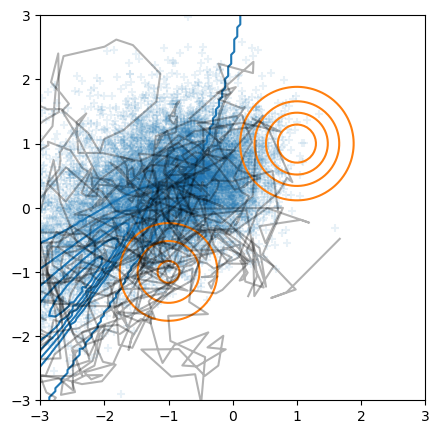

In [ ]:
plot_result(params)

In [ ]:
# # scores = jnp.broadcast_to(scores[:,None], (*ts.shape, d)) # (batch_size, traj_length, dim)
# x1s = jnp.broadcast_to(x1s[:,None], (*ts.shape, d)) # (batch_size, traj_length, dim)
# # ws = jnp.broadcast_to(ws[:,None], ts.shape) # (batch_size, traj_length)
# # scores = scores.reshape(-1, d)
# x1s = x1s.reshape(-1, d)
# # ws = ws.reshape(-1)
# ts = ts.reshape(-1)
